<a href="https://colab.research.google.com/github/shandilya01/Behavioral-Cloning-SelfDrivingCar/blob/master/BehaviouralCloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 37.91 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [ ]:
%tensorflow_version 1.14.0
import tensorflow as tf
tf.__version__

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


'1.15.2'

In [ ]:
!pip3 install imgaug

In [ ]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import sys
import random
import matplotlib.image as mpimg

Using TensorFlow backend.


In [ ]:
datadir = 'track'
cols = ['center' ,'left' ,'right', 'steer', 'throttle', 'reverse','speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'), names = cols)
data.head()

center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_201...  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_201...  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_201...  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_201...  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_201...  ...  0.615438

[5 rows x 7 columns]

In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4053 entries, 0 to 4052
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   center    4053 non-null   object 
 1   left      4053 non-null   object 
 2   right     4053 non-null   object 
 3   steer     4053 non-null   float64
 4   throttle  4053 non-null   float64
 5   reverse   4053 non-null   float64
 6   speed     4053 non-null   float64
dtypes: float64(4), object(3)
memory usage: 221.8+ KB


In [ ]:
len(data)

4053

In [ ]:
len(os.listdir(os.path.join(datadir,'IMG')))

12159

above we see data is consistent by verifying 4053 * 3 = 12159 thus 3 images for each value in data_log.csv files

In [ ]:
os.listdir(os.path.join(datadir,'IMG'))[:5]

['right_2018_07_16_17_14_24_635.jpg',
 'center_2018_07_16_17_15_21_136.jpg',
 'left_2018_07_16_17_13_37_679.jpg',
 'center_2018_07_16_17_13_37_831.jpg',
 'center_2018_07_16_17_15_23_146.jpg']

In [ ]:
import ntpath
def path_leaf(path):
  head ,tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)  
data['left']= data['left'].apply(path_leaf)  
data['right']= data['right'].apply(path_leaf)  
data.head()

center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

In [ ]:
def img_path(ind , strr):
  return str(datadir+'/IMG/'+data[strr][ind])  

def img_show(ind):
  cv2_imshow(cv2.imread(img_path(ind,'left')))
  cv2_imshow(cv2.imread(img_path(ind,'center')))
  cv2_imshow(cv2.imread(img_path(ind, 'right')))


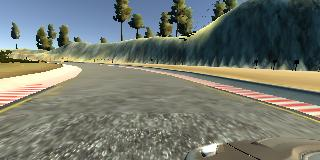

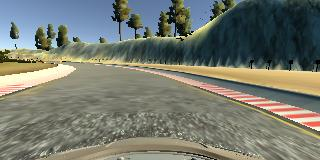

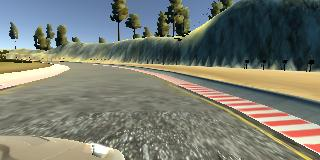

In [ ]:
from google.colab.patches import cv2_imshow
img_show(4)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


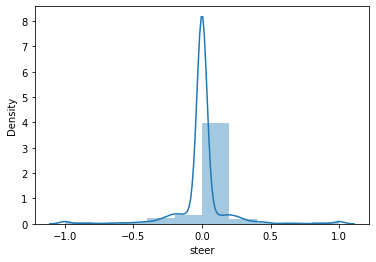

In [ ]:
import seaborn as sns
sns.distplot(data['steer'] ,bins = 10 )

In [ ]:
left=0
right=0
for x in data['steer']:
  if x<0:
    left+=1
  if x>0:
    right+=1

print("leftTurns:",left,"rightTurns:", right) 

leftTurns: 586 rightTurns: 540


just 46 images more are there for left turn than right ones thus pretty balanced out data

In [ ]:
remove_list =[]
for i in range(len(data)):
  if data['steer'][i]==0.0:
    remove_list.append(i)
remove_list= shuffle(remove_list[400:]);
data.drop(data.index[remove_list] , inplace = True)

print(len(data))

1526


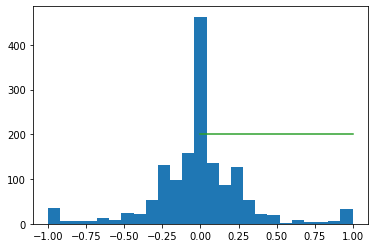

In [ ]:
plt.hist(np.array(data['steer']) , bins=25, histtype='bar')
plt.plot(np.min(data['steer']),np.max(data['steer']), (400,400))
plt.show()

In [ ]:
def load_img_steering(datadir , df):
  image_path=[]
  steering= []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center ,left,right = indexed_data[:3] 
    image_path.append(os.path.join(datadir , center.strip()))  #strip() clears spaces if any
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_path ,steerings

image_paths,steerings = load_img_steering(datadir+'/IMG' ,data)


In [ ]:
X_train ,X_valid, y_train ,y_valid = train_test_split(image_paths , steerings , test_size = 0.2 , random_state =6)

In [ ]:
print(len(X_train),len(X_valid))

1220 306


Text(0.5, 1.0, 'Validation:')

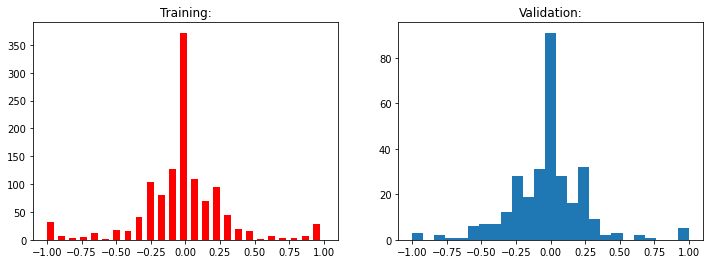

In [ ]:
fig, axes = plt.subplots(1, 2,figsize = (12,4) )
axes[0].hist(y_train , bins=25 ,color='red',width = 0.05)
axes[0].set_title("Training:")
axes[1].hist(y_valid , bins=25) 
axes[1].set_title("Validation:")

In [ ]:
def zoom(image):
  zoom = iaa.Affine(scale=(1,1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

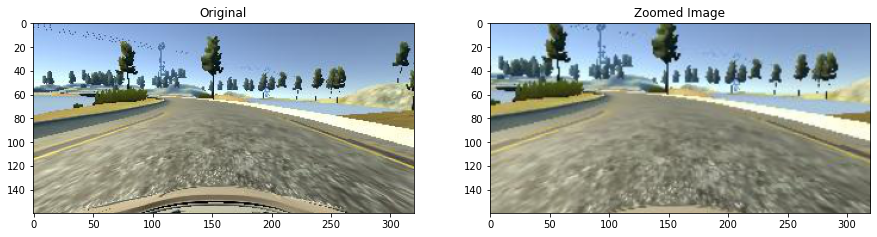

In [ ]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig,axes = plt.subplots(1,2, figsize=(15,10))
axes[0].imshow(original_image)
axes[0].set_title('Original')
axes[1].imshow(zoomed_image)
axes[1].set_title('Zoomed Image')

In [ ]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x" : (-0.1,0.1), "y" : (-0.1,0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

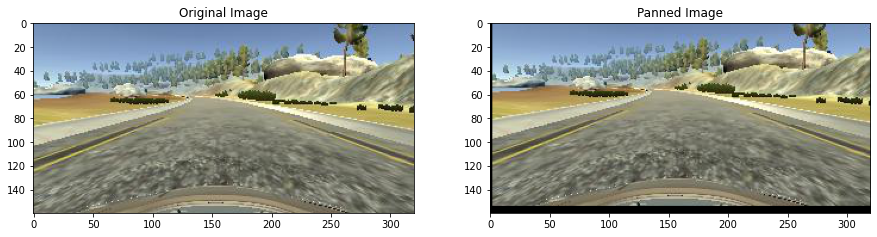

In [ ]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig,axes = plt.subplots(1,2, figsize=(15,10))
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(panned_image)
axes[1].set_title('Panned Image')

In [ ]:
def img_random_brightness(image):
  brightness = iaa.Multiply(mul = (0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness Altered Image')

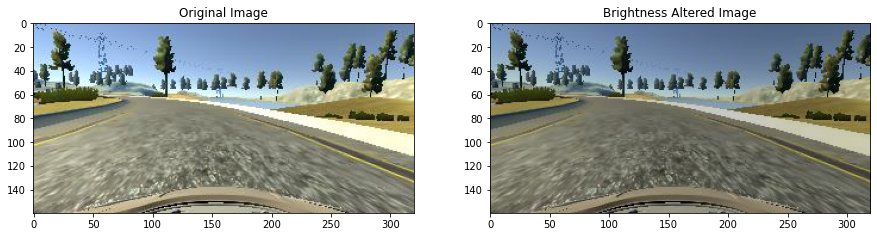

In [ ]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig,axes = plt.subplots(1,2, figsize=(15,10))
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(brightness_altered_image)
axes[1].set_title('Brightness Altered Image')

In [ ]:
def img_random_flip(image , steer_angle):
  image = cv2.flip(image, 1)
  return image , -steer_angle

0.1


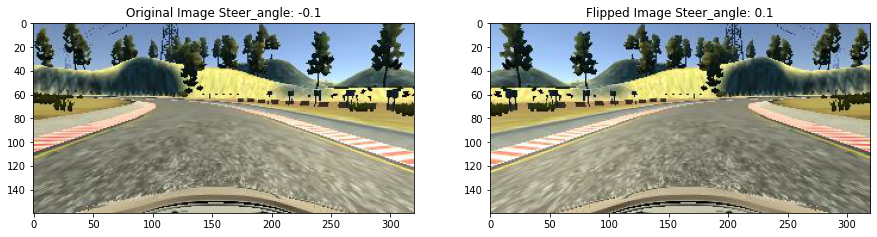

In [ ]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steer_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image , flipped_steer_angle = img_random_flip(original_image , steer_angle)

fig,axes = plt.subplots(1,2, figsize=(15,10))
axes[0].imshow(original_image)
axes[0].set_title('Original Image'+ ' Steer_angle: '+str(steer_angle))
axes[1].imshow(flipped_image)
axes[1].set_title('Flipped Image'+ ' Steer_angle: '+str(flipped_steer_angle))

print(flipped_steer_angle)

In [ ]:
def random_augment(image , steer_angle):
  image = mpimg.imread(image)

  if(np.random.rand() < 0.5):
    image = zoom(image)
  if(np.random.rand() < 0.5):
    image = pan(image)
  if(np.random.rand() < 0.5):
    image = img_random_brightness(image)
  if(np.random.rand() < 0.5):
    image,steer_angle = img_random_flip(image,steer_angle) 

  return image,steer_angle 


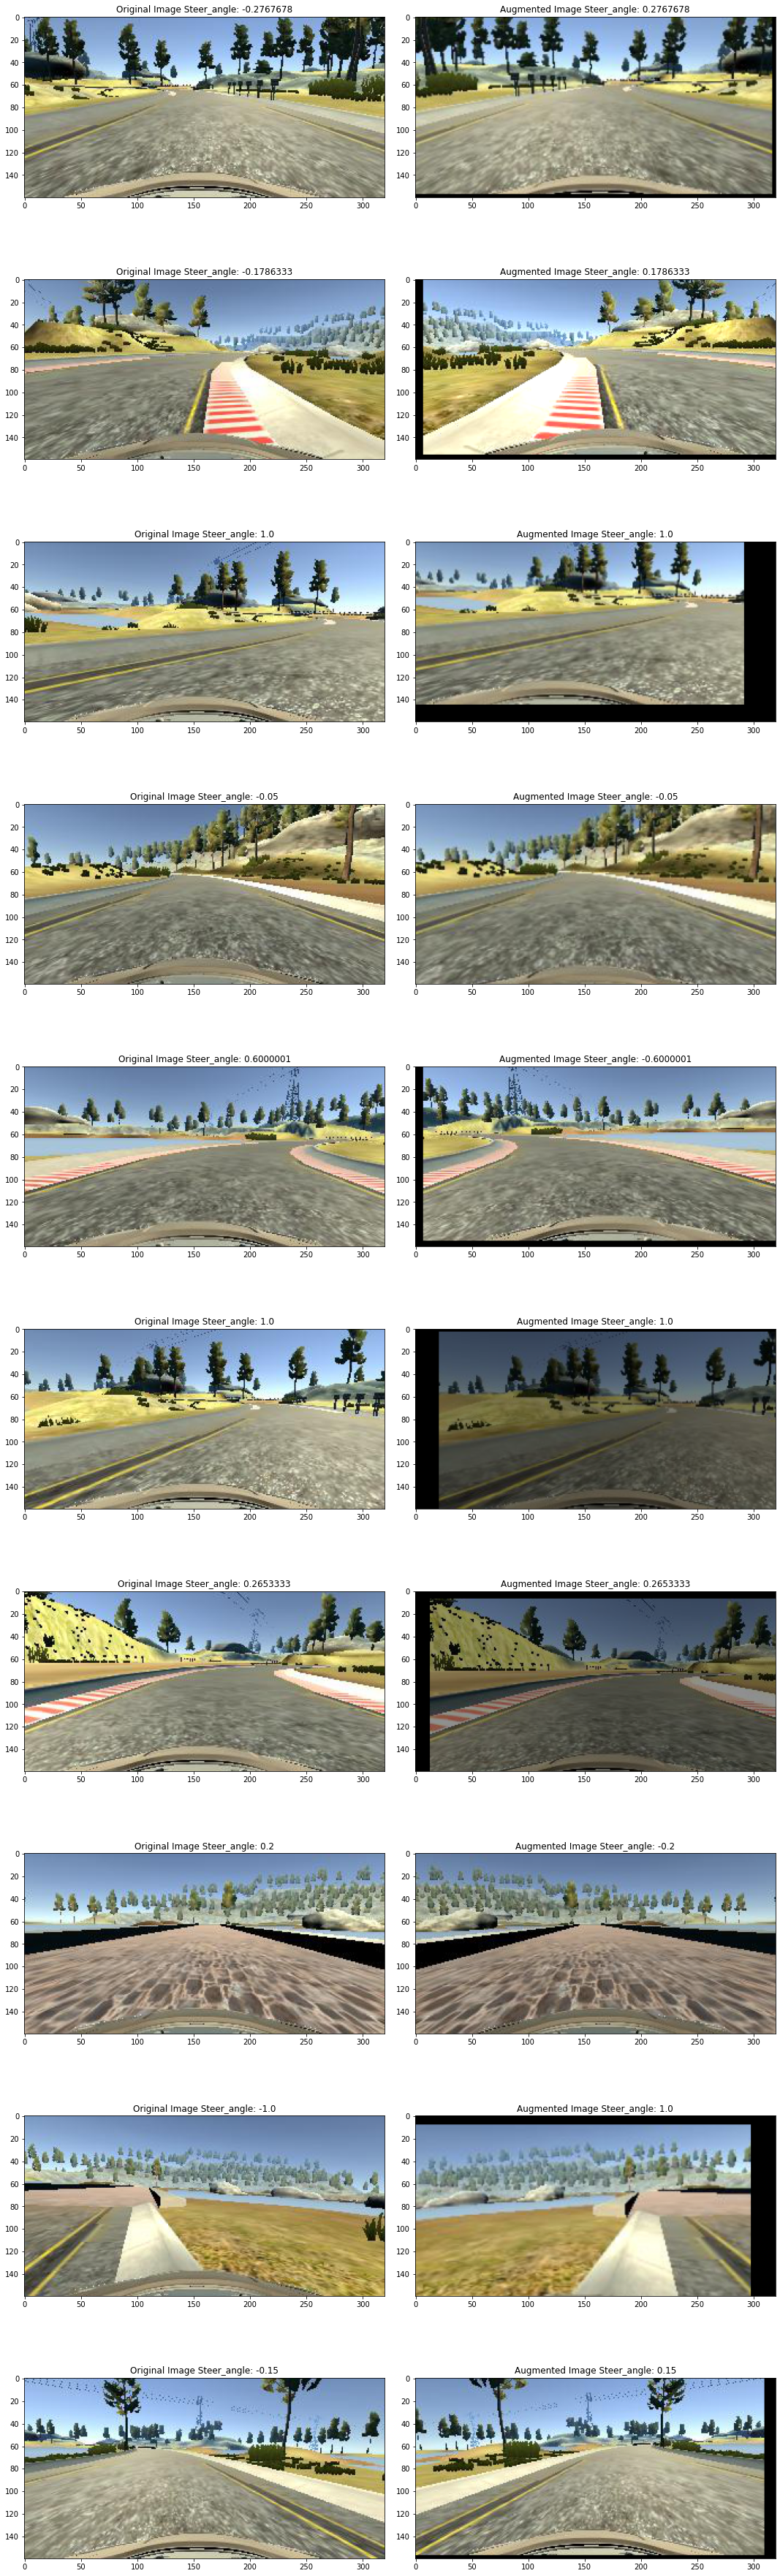

In [ ]:
ncol = 2 
nrow = 10
fig,axes = plt.subplots(nrow,ncol,figsize=(15,50))
fig.tight_layout()

for i in range(10):
  ind = random.randint(0,len(image_paths))
  img = image_paths[ind]
  steer_angle = steerings[ind]

  original_image = mpimg.imread(img)
  augmented_image,augmented_steer_angle = random_augment(img, steer_angle)

  axes[i][0].imshow(original_image)
  axes[i][0].set_title('Original Image'+ ' Steer_angle: '+str(steer_angle))
  axes[i][1].imshow(augmented_image)
  axes[i][1].set_title('Augmented Image'+ ' Steer_angle: '+str(augmented_steer_angle))

In [ ]:
def img_preprocess(img):
  #img = mpimg.imread(img);
  img = img[60:135,:,:]
  img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3),0)
  img = cv2.resize(img , (200,66))                   #change sizes of images
  img = img/255                                      #normalization
  return img

Text(0.5, 1.0, 'preprocessed_Image')

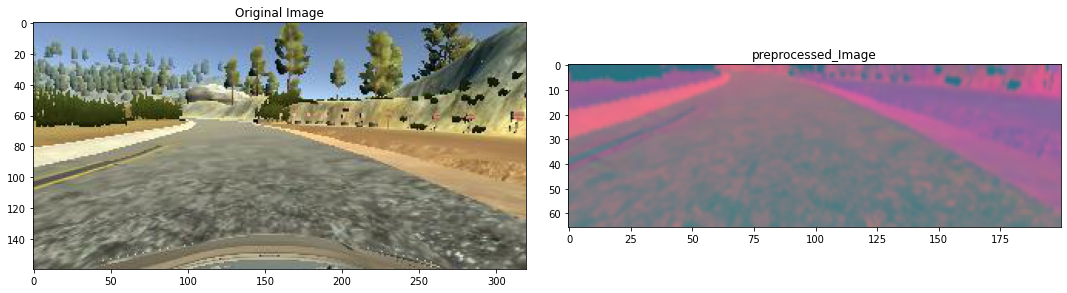

In [ ]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig,axes = plt.subplots(1,2 ,figsize = (15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[1].imshow(preprocessed_image)
axes[1].set_title("preprocessed_Image")

In [ ]:
def batch_generator(image_paths, steering_angle, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0,len(image_paths)-1)

      if istraining:
        im, steering = random_augment(image_paths[random_index],steering_angle[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_angle[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)

    yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Generated image-0.0')

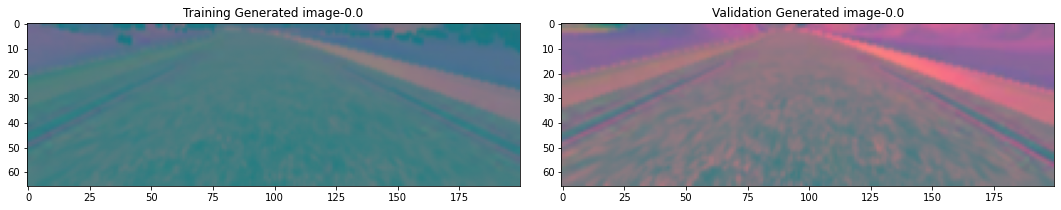

In [ ]:
x_train_gen, y_train_gen  = next(batch_generator(X_train, y_train, 1,1))
x_valid_gen, y_valid_gen  = next(batch_generator(X_valid, y_valid, 1,0))

fig,axes = plt.subplots(1,2 ,figsize=(15,10))
fig.tight_layout();

axes[0].imshow(x_train_gen[0])
axes[0].set_title('Training Generated image-'+str(y_train_gen[0]))

axes[1].imshow(x_valid_gen[0])
axes[1].set_title('Validation Generated image-'+str(y_valid_gen[0]))

In [ ]:
#X_train = np.array(list(map(img_preprocess, X_train)))  
#X_valid = np.array(list(map(img_preprocess, X_valid)))

# CAUTION! :  X_train and X_valid now contains real images instead of paths

In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24,(5,5), strides=(2,2), input_shape= (66,200,3), activation='elu'))
  model.add(Conv2D(36,(5,5), strides=(2,2), activation = 'elu'))
  model.add(Conv2D(48,(5,5), strides=(2,2), activation = 'elu'))
  model.add(Conv2D(64,(3,3), activation = 'elu'))
  model.add(Conv2D(64,(3,3), activation = 'elu'))
  # model.add(Dropout(0.5))                                               # 50% nodes turned to zero

  model.add( Flatten())
  model.add(Dense(100, activation ='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(50, activation ='elu'))
  model.add(Dense(10, activation ='elu'))
  model.add(Dense(1))
  
  optimizer = Adam(lr = 3*(1e-4))
  model.compile(loss = 'mse' , optimizer = optimizer)
  return model


In [ ]:
model = nvidia_model()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_______________________________________

In [ ]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1), 
                              steps_per_epoch = 300 , 
                              epochs=10,
                              validation_data = batch_generator(X_valid,y_valid,100,0),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1
                              )


Epoch 1/15
300/300 [==============================] - 189s 631ms/step - loss: 0.0774 - val_loss: 0.0485
Epoch 2/15
300/300 [==============================] - 179s 598ms/step - loss: 0.0591 - val_loss: 0.0420
Epoch 3/15
300/300 [==============================] - 180s 600ms/step - loss: 0.0547 - val_loss: 0.0681
Epoch 4/15
300/300 [==============================] - 182s 608ms/step - loss: 0.0486 - val_loss: 0.0356
Epoch 5/15
300/300 [==============================] - 182s 605ms/step - loss: 0.0447 - val_loss: 0.0333
Epoch 6/15
300/300 [==============================] - 178s 594ms/step - loss: 0.0406 - val_loss: 0.0290
Epoch 7/15
300/300 [==============================] - 177s 590ms/step - loss: 0.0384 - val_loss: 0.0180
Epoch 8/15
300/300 [==============================] - 178s 594ms/step - loss: 0.0359 - val_loss: 0.0302
Epoch 9/15
300/300 [==============================] - 180s 600ms/step - loss: 0.0343 - val_loss: 0.0218
Epoch 10/15
300/300 [==============================] - 178s 594

Text(0.5, 0, 'Epoch')

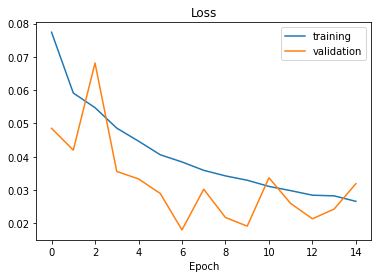

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title("Loss")
plt.xlabel('Epoch')

In [ ]:
model.save('model.h5')

In [ ]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>